In [1]:
import numpy as np
import pandas as pd
from functools import cache
from tqdm import tqdm
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt

# Increasing the dpi makes the plot clearer
plt.rcParams['figure.dpi'] = 300

In [ ]:
# From fetch_data.py
from pybaseball import batting_stats, pitching_stats, schedule_and_record
import pandas as pd
import backoff
from tqdm import tqdm
from itertools import product

# All 2024 Teams
teams = [
    "NYY",
    "KCR",
    "LAD",
    "BAL",
    "NYM",
    "BOS",
    "CLE",
    "CIN",
    "ARI",
    "TOR",
    "SFG",
    "MIL",
    "SEA",
    "HOU",
    "SDP",
    "PHI",
    "OAK",
    "ATL",
    "TEX",
    "MIN",
    "CHC",
    "DET",
    "COL",
    "STL",
    "PIT",
    "LAA",
    "WSN",
    "MIA",
    "TBR",
    "CHW",
]


@backoff.on_exception(backoff.expo, Exception, max_time=60)
def get_batting_stats(season):
    return batting_stats(season, league="all", qual=1, ind=1)


@backoff.on_exception(backoff.expo, Exception, max_time=60)
def get_pitching_stats(season):
    return pitching_stats(season, league="all", qual=1, ind=1)


@backoff.on_exception(backoff.expo, Exception, max_time=60)
def get_schedule(season, team):
    return schedule_and_record(season, team)


def download_batting_stats(season_start=1998):
    print("Downloading batting stats")
    all_stats = []
    for season in tqdm(range(season_start, 2025)):
        try:
            season_stats = get_batting_stats(season)
            all_stats.append(season_stats)
        except Exception as e:
            print(f"Error downloading {season} batting data: {e}")
            continue

    # Save data
    all_stats = pd.concat(all_stats)
    all_stats.to_parquet(
        "data/batting_full.parquet.gz", index=False, compression="gzip"
    )


def download_pitching_stats(season_start=1998):
    print("Downloading pitching stats")
    all_stats = []
    for season in tqdm(range(season_start, 2025)):
        try:
            season_stats = get_pitching_stats(season)
            all_stats.append(season_stats)
        except Exception as e:
            print(f"Error downloading {season} pitching data: {e}")
            continue

    # Save data
    all_stats = pd.concat(all_stats)
    all_stats.to_parquet(
        "data/pitching_full.parquet.gz", index=False, compression="gzip"
    )


def download_schedule(season_start=1998):
    print("Downloading schedules")
    all_stats = []
    for season, team in tqdm(
        product(range(season_start, 2025), teams),
        total=len(teams) * (2025 - season_start),
    ):
        try:
            season_schedule = get_schedule(season, team)
            season_schedule["Season"] = season
            all_stats.append(season_schedule)
        except Exception as e:
            print(f"Error downloading {season} pitching data for {team}: {e}")
            continue

    # Save data
    all_stats = pd.concat(all_stats)
    all_stats.to_parquet(
        "data/schedules_full.parquet.gz", index=False, compression="gzip"
    )


if __name__ == "__main__":
    # download_batting_stats()
    # download_pitching_stats()
    download_schedule()

# Feature Engineering


In [2]:
batting_data = pd.read_parquet("data/batting_full.parquet.gz")
pitching_data = pd.read_parquet("data/pitching_full.parquet.gz")

## Batting


In [3]:
batting_cols = [
    # Meta
    "IDfg",
    "Season",
    "Team",
    "Age",
    # Normalization
    "AB",
    # Stats
    # Bonus
    "R",
    "H",
    "RBI",
    # "Lob",
    "OPS",  # TODO: how to get OPS+?
    "WAR",
    # "OBP+",
    "2B",
    "3B",
    "HR",
    "CS",
    "SB",
    "SO",
    # Left-handed?
]
batting_cleaned = batting_data[batting_cols].dropna()
batting_cleaned = batting_cleaned[batting_cleaned["AB"] > 0]
# Normalize for at-bats
for col in ["R", "H", "RBI", "OPS", "2B", "3B", "HR", "SO", "CS", "SB"]:
    batting_cleaned[col] /= batting_cleaned["AB"]
batting_cleaned.rename(columns={"AB": "weight"}, inplace=True)

In [5]:
batting_cleaned.head()

IDfg  Season Team  Age  weight         R         H       RBI       OPS  \
0  1008559    1998  STL   34     509  0.255403  0.298625  0.288802  0.002401   
1     1109    1998  SFG   33     552  0.217391  0.302536  0.221014  0.001897   
2     1093    1998  NYM   29     557  0.163375  0.353680  0.166966  0.001792   
3     1274    1998  SEA   22     686  0.179300  0.310496  0.180758  0.001340   
4      190    1998  BOS   24     604  0.183775  0.322848  0.201987  0.001566   

   WAR        2B        3B        HR        CS        SB        SO  
0  8.5  0.041257  0.000000  0.137525  0.000000  0.001965  0.304519  
1  8.5  0.079710  0.012681  0.067029  0.021739  0.050725  0.166667  
2  8.1  0.064632  0.007181  0.039497  0.003591  0.003591  0.131059  
3  7.9  0.051020  0.007289  0.061224  0.018950  0.067055  0.176385  
4  7.3  0.061258  0.013245  0.057947  0.009934  0.019868  0.102649

In [6]:
# Save
batting_cleaned.to_parquet("data/batting_cleaned.parquet.gz", compression="gzip")

## Pitching


In [7]:
pitching_cols = [
    # Meta
    "IDfg",
    "Season",
    "Team",
    "Age",
    # Normalization
    "TBF",
    # Stats
    "ERA-",
    "H",
    "HR",
    "BB",
    "SO",
]

pitching_cleaned = pitching_data[pitching_cols].dropna()
pitching_cleaned = pitching_cleaned[pitching_cleaned["TBF"] > 0]
# Normalize for batters faced
for col in ["H", "HR", "BB", "SO"]:
    pitching_cleaned[col] /= pitching_cleaned["TBF"]
pitching_cleaned.rename(columns={"TBF": "weight"}, inplace=True)

In [8]:
pitching_cleaned.head()

IDfg  Season   Team  Age  weight  ERA-         H        HR        BB  \
0   642    1998    SDP   33    1032    60  0.218023  0.007752  0.047481   
1    73    1998    PHI   31    1089    76  0.216713  0.021120  0.056015   
2   815    1998    TOR   35     961    57  0.175858  0.011446  0.091571   
3    60    1998  - - -   34    1014    72  0.200197  0.022682  0.084813   
4   104    1998    ATL   32     987    53  0.203647  0.013171  0.045593   

         SO  
0  0.249031  
1  0.275482  
2  0.281998  
3  0.324458  
4  0.206687

In [9]:
#  Save
pitching_cleaned.to_parquet("data/pitching_cleaned.parquet.gz", compression="gzip")

## Schedule/Record


In [10]:
curr_teams = [
    "NYY",
    "KCR",
    "LAD",
    "BAL",
    "NYM",
    "BOS",
    "CLE",
    "CIN",
    "ARI",
    "TOR",
    "SFG",
    "MIL",
    "SEA",
    "HOU",
    "SDP",
    "PHI",
    "OAK",
    "ATL",
    "TEX",
    "MIN",
    "CHC",
    "DET",
    "COL",
    "STL",
    "PIT",
    "LAA",
    "WSN",
    "MIA",
    "TBR",
    "CHW",
]

renames = {
    "ANA": "LAA",
    "FLA": "MIA",
    "MON": "WSN",
    "TBD": "TBR",
}

In [11]:
schedules = pd.read_parquet("data/schedules_full.parquet.gz")

In [12]:
schedules.head()

Date   Tm Home_Away  Opp W/L    R    RA   Inn  W-L  Rank  ...  \
0  Wednesday, Apr 1  NYY         @  ANA   L  1.0   4.0   9.0  0-1   5.0  ...   
1   Thursday, Apr 2  NYY         @  ANA   L  2.0  10.0   9.0  0-2   5.0  ...   
2   Saturday, Apr 4  NYY         @  OAK   L  3.0   7.0   9.0  0-3   5.0  ...   
3     Sunday, Apr 5  NYY         @  OAK   W  9.0   7.0  10.0  1-3   5.0  ...   
4     Monday, Apr 6  NYY         @  SEA   L  0.0   8.0   9.0  1-4   5.0  ...   

      Win      Loss      Save  Time D/N Attendance   cLI Streak  \
0  Finley  Pettitte  Percival  2:52   N    43311.0  1.00   -1.0   
1    Hill     Wells      None  3:19   N    29899.0   .95   -2.0   
2  Haynes      Cone      None  2:57   D    17118.0   .93   -3.0   
3  Nelson    Mohler      None  4:15   D    18109.0   .84    1.0   
4   Moyer  Pettitte      None  3:08   N    27445.0   .88   -1.0   

   Orig. Scheduled Season  
0             None   1998  
1             None   1998  
2             None   1998  
3             None   1998  
4             None   1998  

[5 rows x 21 columns]

In [13]:
def add_momentum_columns(df, prefix):
    # Remove win/loss of current game from season record to prevent data leakage
    won = df["W/L"].apply(lambda x: 1 if x == "W" else 0)
    lost = df["W/L"].apply(lambda x: 1 if x == "L" else 0)
    season_wins = df["W-L"].str.split("-").str[0].astype(int) - won
    season_losses = df["W-L"].str.split("-").str[1].astype(int) - lost

    df[prefix + "_wins_pct"] = (season_wins / (season_wins + season_losses)).fillna(0.5)
    df.drop(columns=["W/L", "W-L"], inplace=True)

In [14]:
# Get rid of data leakage in streak
def fix_streaks(df):
    for season in df.Season.unique():
        season_df = df[df.Season == season]
        for team in season_df.HomeTeam.unique():
            # Filter rows for the current team
            team_indices = (df.Season == season) & (df.HomeTeam == team)
            team_df = df.loc[team_indices]

            # Roll streaks forward
            df.loc[team_indices, "Streak"] = team_df.Streak.shift(1)

    # Fill NaN values with 0
    df.Streak.fillna(0, inplace=True)

In [15]:
schedules_cleaned = schedules[
    ["Tm", "Opp", "W/L", "W-L", "D/N", "Home_Away", "Season", "Date", "Streak"]
].copy()
# Rename columns
schedules_cleaned.rename(columns={"Tm": "HomeTeam", "Opp": "AwayTeam"}, inplace=True)
# Rename Teams: TODO: figure out why this isn't working
# schedules_cleaned["Tm"] = schedules_cleaned["Tm"].replace(renames)
# schedules_cleaned["Opp"] = schedules_cleaned["Opp"].replace(renames)
# Drop non-current teams
schedules_cleaned = schedules_cleaned[
    schedules_cleaned["HomeTeam"].isin(curr_teams)
    & schedules_cleaned["AwayTeam"].isin(curr_teams)
]
# Drop pre-1999
schedules_cleaned = schedules_cleaned[schedules_cleaned["Season"] > 1998]
# Drop ties
schedules_cleaned = schedules_cleaned[schedules_cleaned["W/L"] != "T"]
# Roll streak forward to avoid data leakage
fix_streaks(schedules_cleaned)

# Add dummies
schedules_cleaned["Day"] = schedules_cleaned["D/N"].str.contains("D").astype(int)
schedules_cleaned["Win"] = schedules_cleaned["W/L"].str.contains("W").astype(int)

# Add momentum columns + drop home games
home_mask = schedules_cleaned["Home_Away"] == "Home"
away_games = schedules_cleaned[~home_mask].copy()
home_games = schedules_cleaned[home_mask].copy()
add_momentum_columns(away_games, "away")
add_momentum_columns(home_games, "home")

In [16]:
away_games.head()

HomeTeam AwayTeam D/N Home_Away  Season              Date  Streak  Day  \
4216      NYY      OAK   N         @    1999     Monday, Apr 5     0.0    0   
4217      NYY      OAK   N         @    1999    Tuesday, Apr 6    -1.0    0   
4218      NYY      OAK   D         @    1999  Wednesday, Apr 7     1.0    1   
4225      NYY      DET   N         @    1999    Friday, Apr 16    -1.0    0   
4226      NYY      DET   D         @    1999  Saturday, Apr 17    -2.0    1   

      Win  away_wins_pct  
4216    0       0.500000  
4217    1       0.000000  
4218    1       0.500000  
4225    0       0.777778  
4226    0       0.700000

In [17]:
# # Merge home and away games
schedules_cleaned = pd.merge(
    home_games,
    away_games,
    left_on=["Date", "Season", "HomeTeam"],
    right_on=["Date", "Season", "AwayTeam"],
    suffixes=(None, "_away"),
    validate="1:1",
)
schedules_cleaned.rename(
    columns={"Streak": "home_streak", "Streak_away": "away_streak"}, inplace=True
)
schedules_cleaned.drop(
    columns=schedules_cleaned.columns[schedules_cleaned.columns.str.endswith("_away")],
    inplace=True,
)
schedules_cleaned.drop(columns=["D/N", "Home_Away"], inplace=True)

In [18]:
schedules_cleaned.head(20)

HomeTeam AwayTeam  Season               Date  home_streak  Day  Win  \
0       NYY      DET    1999      Friday, Apr 9          2.0    1    1   
1       NYY      DET    1999   Saturday, Apr 10          3.0    1    1   
2       NYY      DET    1999     Sunday, Apr 11          4.0    1    1   
3       NYY      BAL    1999    Tuesday, Apr 13          5.0    0    1   
4       NYY      BAL    1999  Wednesday, Apr 14          6.0    0    1   
5       NYY      BAL    1999   Thursday, Apr 15          7.0    0    0   
6       NYY      TEX    1999    Tuesday, Apr 20         -4.0    0    1   
7       NYY      TEX    1999  Wednesday, Apr 21          1.0    0    1   
8       NYY      TOR    1999     Friday, Apr 23          2.0    0    1   
9       NYY      TOR    1999   Saturday, Apr 24          3.0    1    1   
10      NYY      TOR    1999     Sunday, Apr 25          4.0    1    1   
11      NYY      SEA    1999      Friday, May 7          2.0    0    1   
12      NYY      SEA    1999    Saturday, May 8          3.0    1    0   
13      NYY      SEA    1999      Sunday, May 9         -1.0    1    1   
14      NYY      CHW    1999     Friday, May 14          1.0    0    0   
15      NYY      CHW    1999   Saturday, May 15         -4.0    1    0   
16      NYY      CHW    1999     Sunday, May 16         -5.0    1    1   
17      NYY      BOS    1999    Tuesday, May 25          1.0    0    0   
18      NYY      BOS    1999  Wednesday, May 26         -1.0    1    1   
19      NYY      BOS    1999   Thursday, May 27          1.0    0    1   

    home_wins_pct  away_streak  away_wins_pct  
0        0.666667         -2.0       0.333333  
1        0.750000         -3.0       0.250000  
2        0.800000         -4.0       0.200000  
3        0.833333         -1.0       0.333333  
4        0.857143         -2.0       0.285714  
5        0.875000         -3.0       0.250000  
6        0.583333          1.0       0.538462  
7        0.615385         -1.0       0.500000  
8        0.642857          5.0       0.750000  
9        0.666667         -1.0       0.705882  
10       0.705882         -2.0       0.631579  
11       0.666667         -1.0       0.464286  
12       0.678571         -2.0       0.448276  
13       0.655172          1.0       0.466667  
14       0.606061         -1.0       0.516129  
15       0.588235          1.0       0.531250  
16       0.571429          2.0       0.545455  
17       0.571429          3.0       0.604651  
18       0.558140          4.0       0.613636  
19       0.568182         -1.0       0.600000

In [19]:
assert schedules_cleaned.isna().sum().sum() == 0
schedules_cleaned.to_parquet("data/schedules_cleaned.parquet.gz", compression="gzip")
schedules_cleaned.head()

HomeTeam AwayTeam  Season               Date  home_streak  Day  Win  \
0      NYY      DET    1999      Friday, Apr 9          2.0    1    1   
1      NYY      DET    1999   Saturday, Apr 10          3.0    1    1   
2      NYY      DET    1999     Sunday, Apr 11          4.0    1    1   
3      NYY      BAL    1999    Tuesday, Apr 13          5.0    0    1   
4      NYY      BAL    1999  Wednesday, Apr 14          6.0    0    1   

   home_wins_pct  away_streak  away_wins_pct  
0       0.666667         -2.0       0.333333  
1       0.750000         -3.0       0.250000  
2       0.800000         -4.0       0.200000  
3       0.833333         -1.0       0.333333  
4       0.857143         -2.0       0.285714

## Add Player Features to Schedules


In [20]:
@cache
def get_players(Team, Season):
    batting = batting_cleaned[
        (batting_cleaned["Team"] == Team) & (batting_cleaned["Season"] == Season)
    ]["IDfg"].unique()
    pitching = pitching_cleaned[
        (pitching_cleaned["Team"] == Team) & (pitching_cleaned["Season"] == Season)
    ]["IDfg"].unique()
    return batting, pitching

In [21]:
@cache
def get_team_stats(Team, Season):
    batting_players, pitching_players = get_players(Team, Season)
    if len(batting_players) == 0 or len(pitching_players) == 0:
        raise ValueError("No players", Team, Season)
    agg = {}

    # BATTING
    prior_season_batting = []
    batting_rookies = 0
    for player in batting_players:
        player_data = batting_cleaned[
            (batting_cleaned["IDfg"] == player)
            & (batting_cleaned["Season"] == Season - 1)
        ]
        if len(player_data) == 0:
            batting_rookies += 1
        else:
            prior_season_batting.append(player_data)
    if len(prior_season_batting) == 0:
        raise ValueError("No prior season batting data", Team, Season)

    batting_data = pd.concat(prior_season_batting)
    batting_data.drop(columns=["IDfg", "Season", "Team"], inplace=True)
    for col in batting_data.columns:
        if col == "weight":
            continue
        weights = batting_data["weight"].to_numpy()
        weighted_mean = np.average(batting_data[col], weights=weights)
        agg[f"batting_{col}_mean"] = weighted_mean
        # Bessel's correction for unbiased weighted sample variance
        agg[f"batting_{col}_var"] = np.sum(
            weights * (batting_data[col] - weighted_mean) ** 2
        ) / (np.sum(weights) - 1)
    agg["batting_rookies"] = batting_rookies

    # PITCHING
    prior_season_pitching = []
    pitching_rookies = 0
    for player in pitching_players:
        player_data = pitching_cleaned[
            (pitching_cleaned["IDfg"] == player)
            & (pitching_cleaned["Season"] == Season - 1)
        ]
        if len(player_data) == 0:
            pitching_rookies += 1
        else:
            prior_season_pitching.append(player_data)
    if len(prior_season_pitching) == 0:
        raise ValueError("No prior season pitching data", Team, Season)

    pitching_data = pd.concat(prior_season_pitching)
    pitching_data.drop(columns=["IDfg", "Season", "Team"], inplace=True)
    for col in pitching_data.columns:
        if col == "weight":
            continue
        weights = pitching_data["weight"].to_numpy()
        weighted_mean = np.average(pitching_data[col], weights=weights)
        agg[f"pitching_{col}_mean"] = weighted_mean
        # Bessel's correction for unbiased weighted sample variance
        agg[f"pitching_{col}_var"] = np.sum(
            weights * (pitching_data[col] - weighted_mean) ** 2
        ) / (np.sum(weights) - 1)
    agg["pitching_rookies"] = pitching_rookies

    return agg


In [22]:
new_rows = []
for season in tqdm(schedules_cleaned.Season.unique()):
    season_df = schedules_cleaned[schedules_cleaned.Season == season]
    season_teams = set(season_df.HomeTeam.unique()) | set(season_df.AwayTeam.unique())

    for team1, team2 in combinations(season_teams, 2):
        team1_matchups = season_df[
            (season_df["HomeTeam"] == team1) & (season_df["AwayTeam"] == team2)
        ]
        team2_matchups = season_df[
            (season_df["HomeTeam"] == team2) & (season_df["AwayTeam"] == team1)
        ]
        if len(team1_matchups) == 0 or len(team2_matchups) == 0:
            continue
        team1_stats = get_team_stats(team1, season)
        team2_stats = get_team_stats(team2, season)

        features = {}
        for key, value in team1_stats.items():
            features[f"team1_{key}"] = value
        for key, value in team2_stats.items():
            features[f"team2_{key}"] = value
        features["Season"] = season
        features["win_rate"] = team1_matchups["Win"].mean()

        # Check for nan
        if np.isnan(features["win_rate"]):
            print("AHHH", team1_matchups.Win[:10])
            continue

        # Add row
        new_rows.append(features)

new_df = pd.DataFrame(new_rows)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:24<00:00,  1.06it/s]


In [23]:
new_features = []
for i, row in tqdm(schedules_cleaned.iterrows(), total=len(schedules_cleaned)):
    home_team = row["HomeTeam"]
    away_team = row["AwayTeam"]
    season = row["Season"]
    features = {}
    home_stats = get_team_stats(home_team, season)
    for key, value in home_stats.items():
        if np.isnan(value):
            print(home_team, season, key)
        features[f"home_{key}"] = value
    away_stats = get_team_stats(away_team, season)
    for key, value in away_stats.items():
        if np.isnan(value):
            print(away_team, season, key)
        features[f"away_{key}"] = value
    new_features.append(features)
new_features = pd.DataFrame(new_features)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56347/56347 [00:03<00:00, 14276.72it/s]


In [24]:
# Day/Month Features
schedules_cleaned["Day"] = schedules_cleaned["Date"].str.split(",").str[0].str.lower()
schedules_cleaned["Month"] = schedules_cleaned["Date"].str.split().str[1].str.lower()
# Add Dummies
day_dummies = pd.get_dummies(schedules_cleaned["Day"])
month_dummies = pd.get_dummies(schedules_cleaned["Month"])
schedules_cleaned = pd.concat([schedules_cleaned, day_dummies, month_dummies], axis=1)
schedules_cleaned.drop(columns=["Day", "Month"], inplace=True)

In [25]:
final_data = pd.concat(
    [schedules_cleaned.reset_index(drop=True), new_features.reset_index(drop=True)],
    axis=1,
)
assert final_data.isna().sum().sum() == 0
final_data.to_parquet("data/final_data.parquet.gz", compression="gzip")
final_data.head()

HomeTeam AwayTeam  Season               Date  home_streak  Win  \
0      NYY      DET    1999      Friday, Apr 9          2.0    1   
1      NYY      DET    1999   Saturday, Apr 10          3.0    1   
2      NYY      DET    1999     Sunday, Apr 11          4.0    1   
3      NYY      BAL    1999    Tuesday, Apr 13          5.0    1   
4      NYY      BAL    1999  Wednesday, Apr 14          6.0    1   

   home_wins_pct  away_streak  away_wins_pct  friday  ...  \
0       0.666667         -2.0       0.333333    True  ...   
1       0.750000         -3.0       0.250000   False  ...   
2       0.800000         -4.0       0.200000   False  ...   
3       0.833333         -1.0       0.333333   False  ...   
4       0.857143         -2.0       0.285714   False  ...   

   away_pitching_ERA-_var  away_pitching_H_mean  away_pitching_H_var  \
0              270.105447              0.231144             0.000500   
1              270.105447              0.231144             0.000500   
2              270.105447              0.231144             0.000500   
3              480.827063              0.245114             0.000671   
4              480.827063              0.245114             0.000671   

   away_pitching_HR_mean  away_pitching_HR_var  away_pitching_BB_mean  \
0               0.027963              0.000128               0.087224   
1               0.027963              0.000128               0.087224   
2               0.027963              0.000128               0.087224   
3               0.024324              0.000025               0.075676   
4               0.024324              0.000025               0.075676   

   away_pitching_BB_var  away_pitching_SO_mean  away_pitching_SO_var  \
0              0.000674               0.159312               0.00114   
1              0.000674               0.159312               0.00114   
2              0.000674               0.159312               0.00114   
3              0.000484               0.169439               0.00182   
4              0.000484               0.169439               0.00182   

   away_pitching_rookies  
0                      8  
1                      8  
2                      8  
3                      4  
4                      4  

[5 rows x 100 columns]

# Exploratory Data Analysis

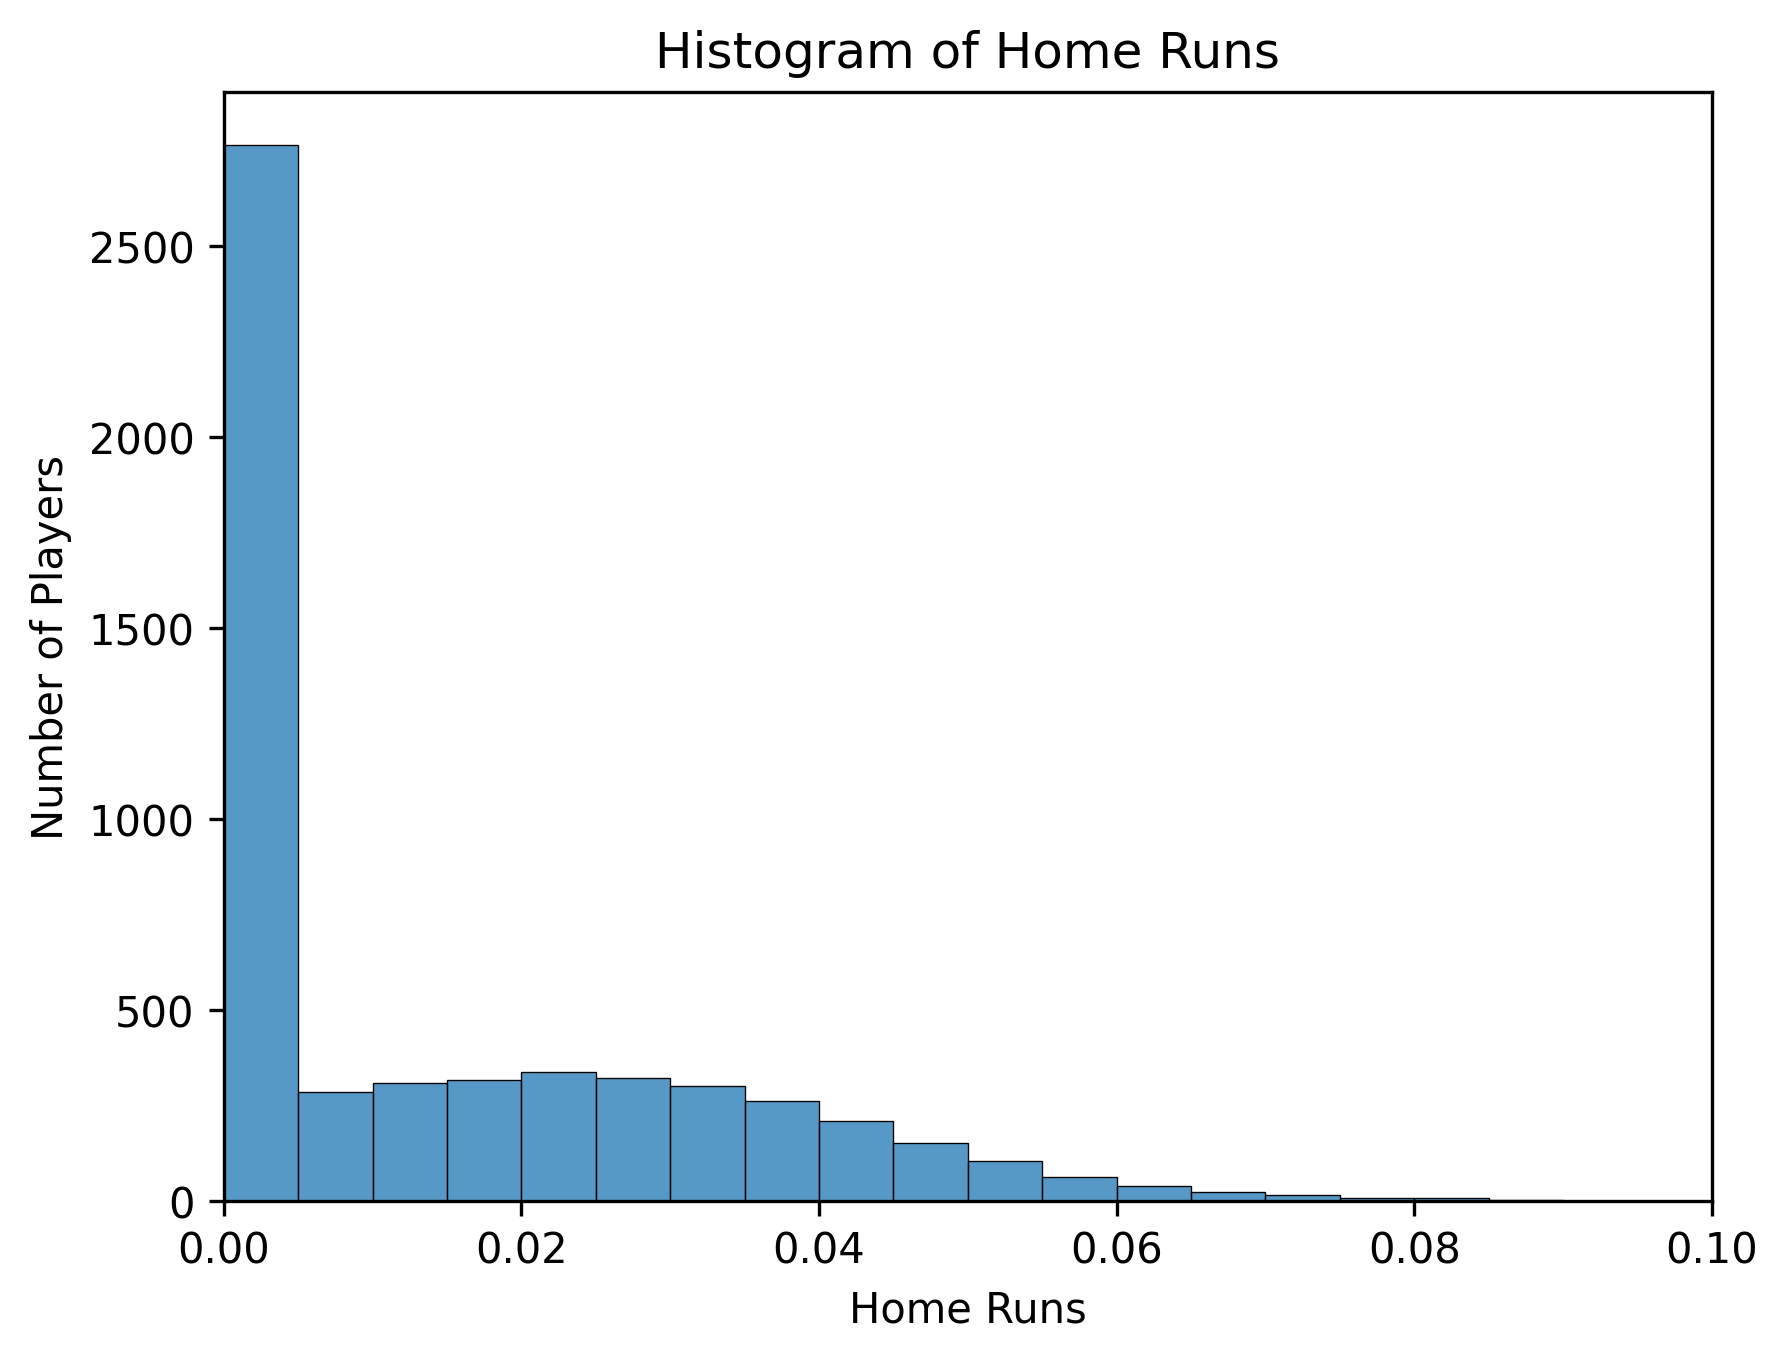

In [26]:
# Getting the ID for each of the batters
batter_ids = batting_cleaned['IDfg'].unique()

# Using the numpy weighted average function to calculate the average home runs per player
batting_hr = []
for batter_id in batter_ids:
    batter = batting_cleaned[batting_cleaned['IDfg'] == batter_id]
    hr = np.average(batter['HR'], weights=batter['weight'])
    batting_hr.append([batter_id, hr])

batter_hr = pd.DataFrame(batting_hr, columns=['batter_id', 'HR'])

# Plottin the histogram of the home runs
sns.histplot(batter_hr['HR'], bins=100)
plt.xlabel('Home Runs')
plt.ylabel('Number of Players')
plt.title('Histogram of Home Runs')
plt.xlim(0, 0.1)
plt.show()

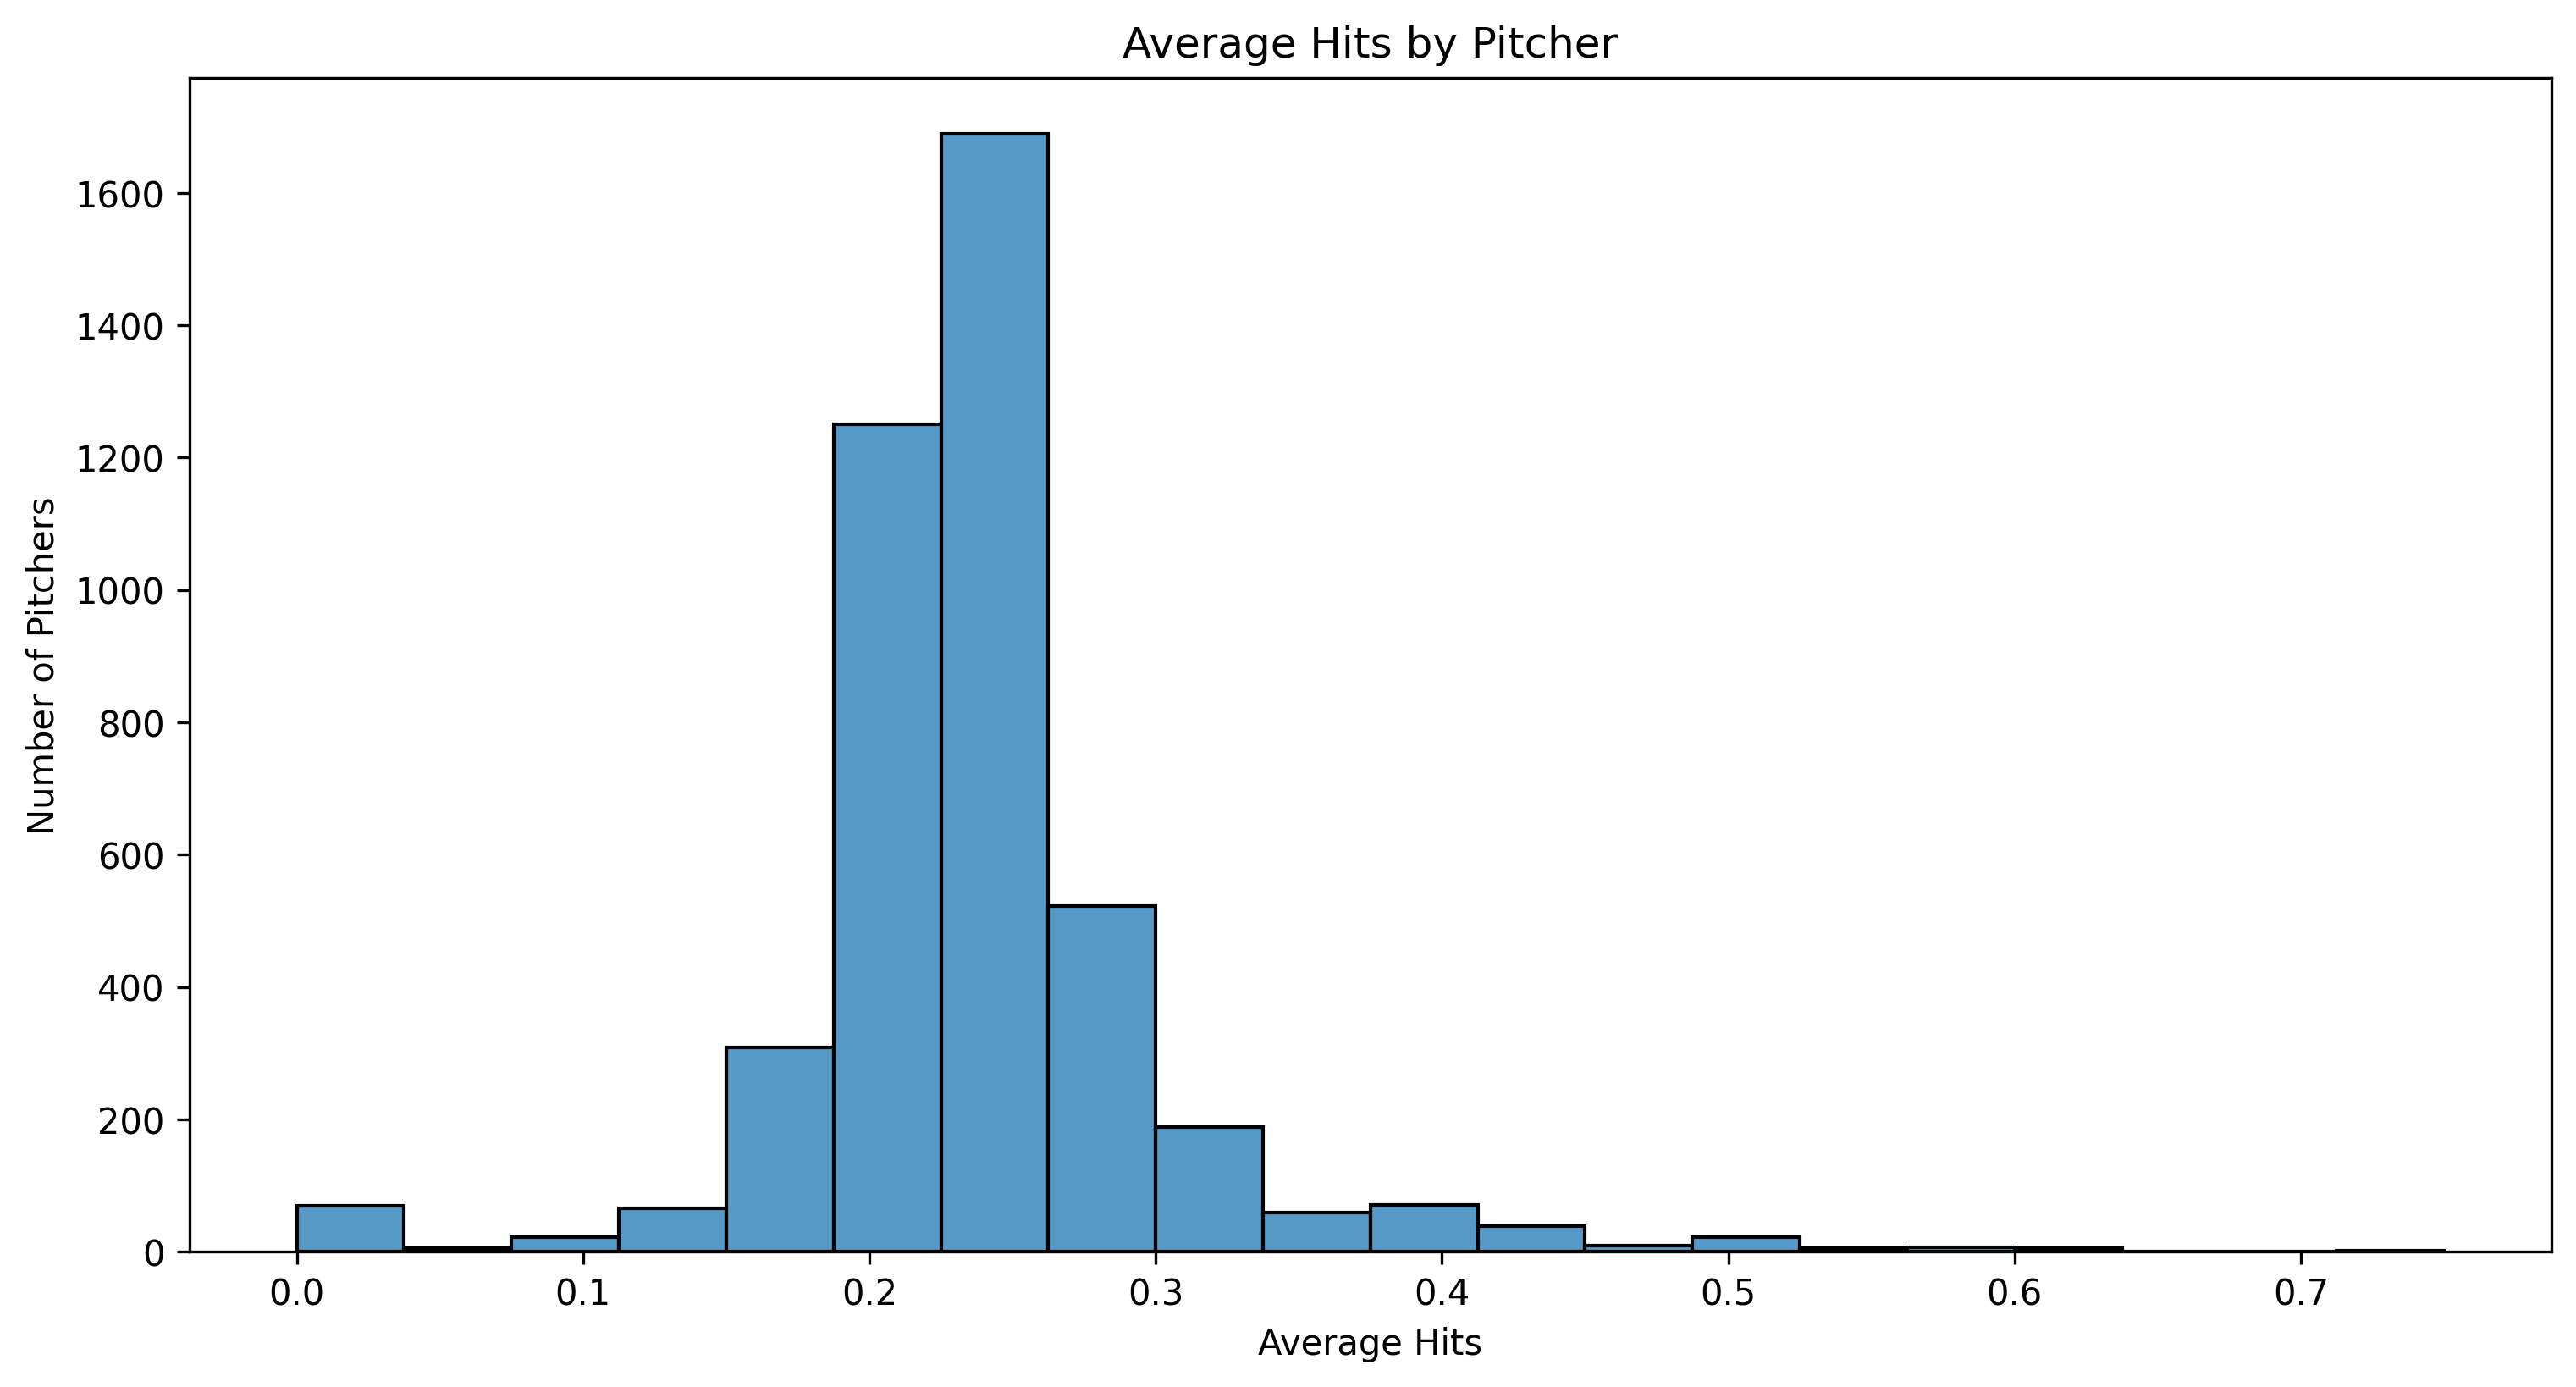

In [27]:
# Getting the values IDs for the pitchers
pitcher_ids = pitching_cleaned["IDfg"].unique()

# Using numpy weighted average to average the hits by pitcher and then creating a new dataframe
pitcher_hits = []
for pitcher in pitcher_ids:
    pitcher_cleaned = pitching_cleaned[pitching_cleaned["IDfg"] == pitcher]
    pitcher_hits.append(np.average(pitcher_cleaned["H"], weights=pitcher_cleaned["weight"]))

pitcher_hits_df = pd.DataFrame({"IDfg": pitcher_ids, "H": pitcher_hits})

# Plotting a histogram of the average hits by pitcher
plt.figure(figsize=(12, 6))
sns.histplot(pitcher_hits_df["H"], bins=20)
plt.title("Average Hits by Pitcher")
plt.xlabel("Average Hits")
plt.ylabel("Number of Pitchers")
plt.show()


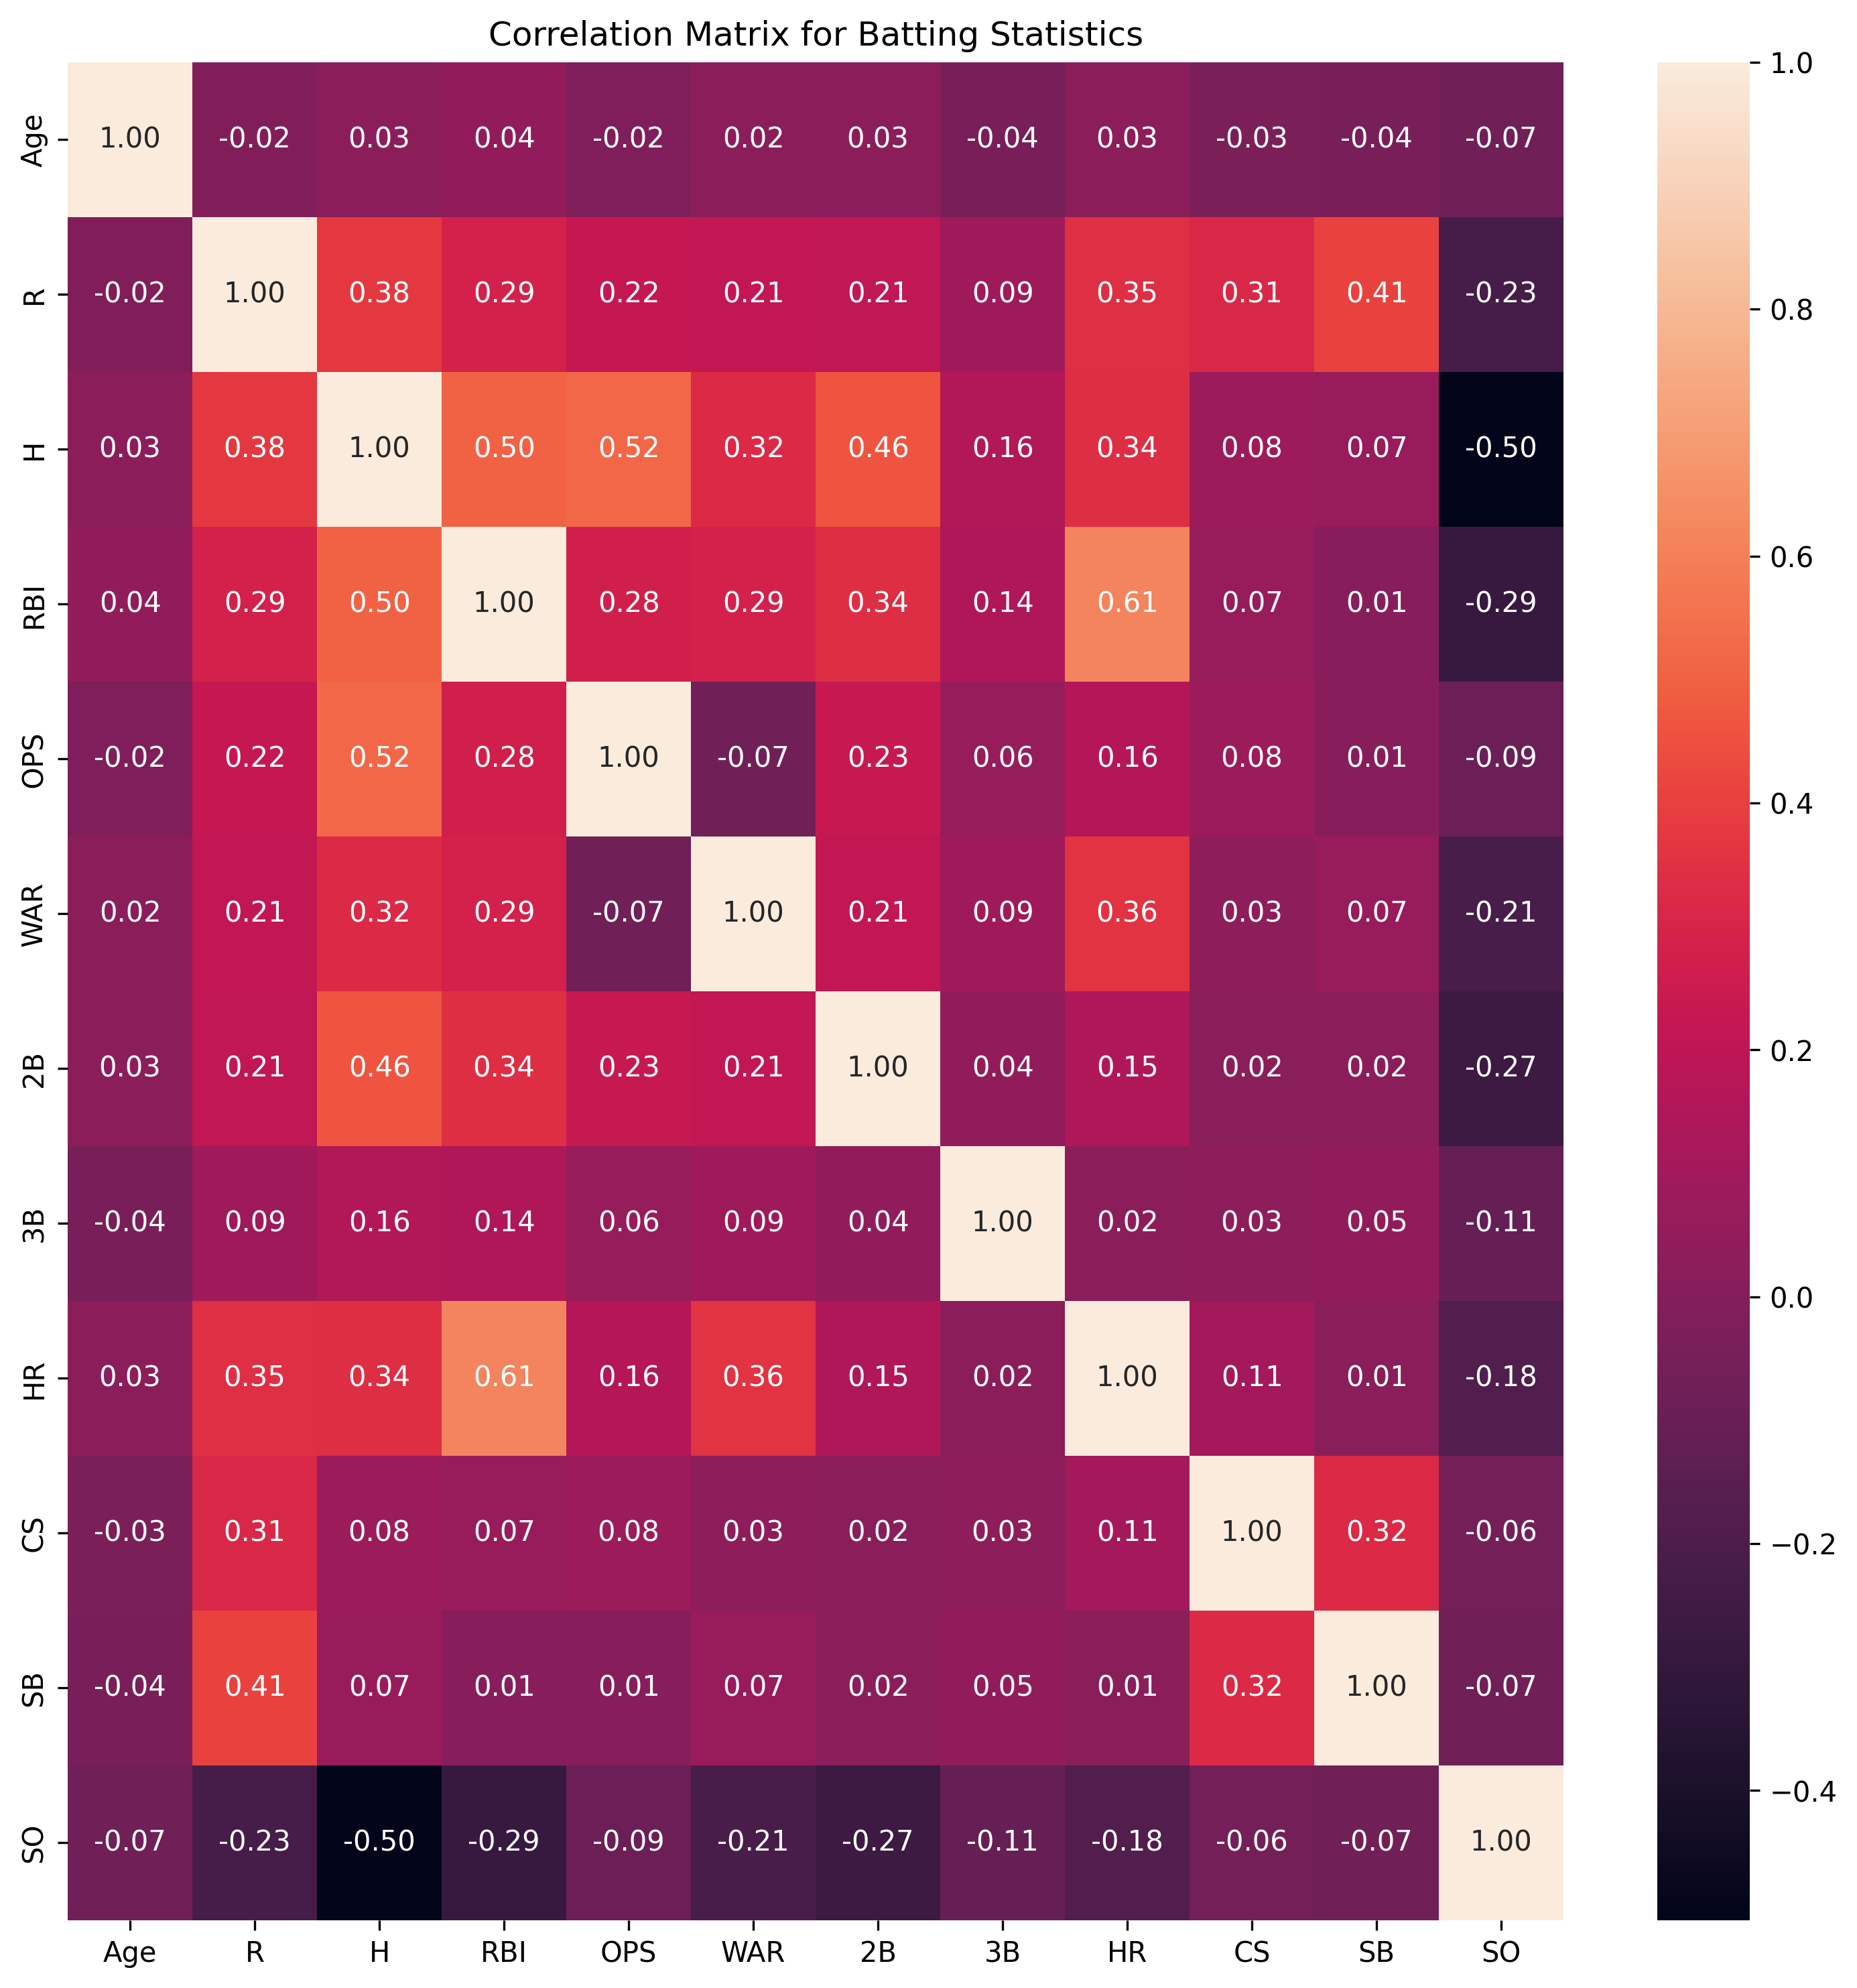

In [28]:
# Creating a correlation matrix for all of the batting statistics and pitching statistics
# Dropping the playerID, Team, and Season columns
batting = batting_cleaned.drop(columns=["IDfg", "Team", "Season", "weight"])
pitching = pitching_cleaned.drop(columns=["IDfg", "Team", "Season", "weight"])


batting_corr = batting.corr()
pitching_corr = pitching.corr()

# Plotting the correlation matrix for batting statistics
plt.figure(figsize=(12, 12))
sns.heatmap(batting_corr, annot=True, fmt=".2f")
plt.title("Correlation Matrix for Batting Statistics")
plt.show()

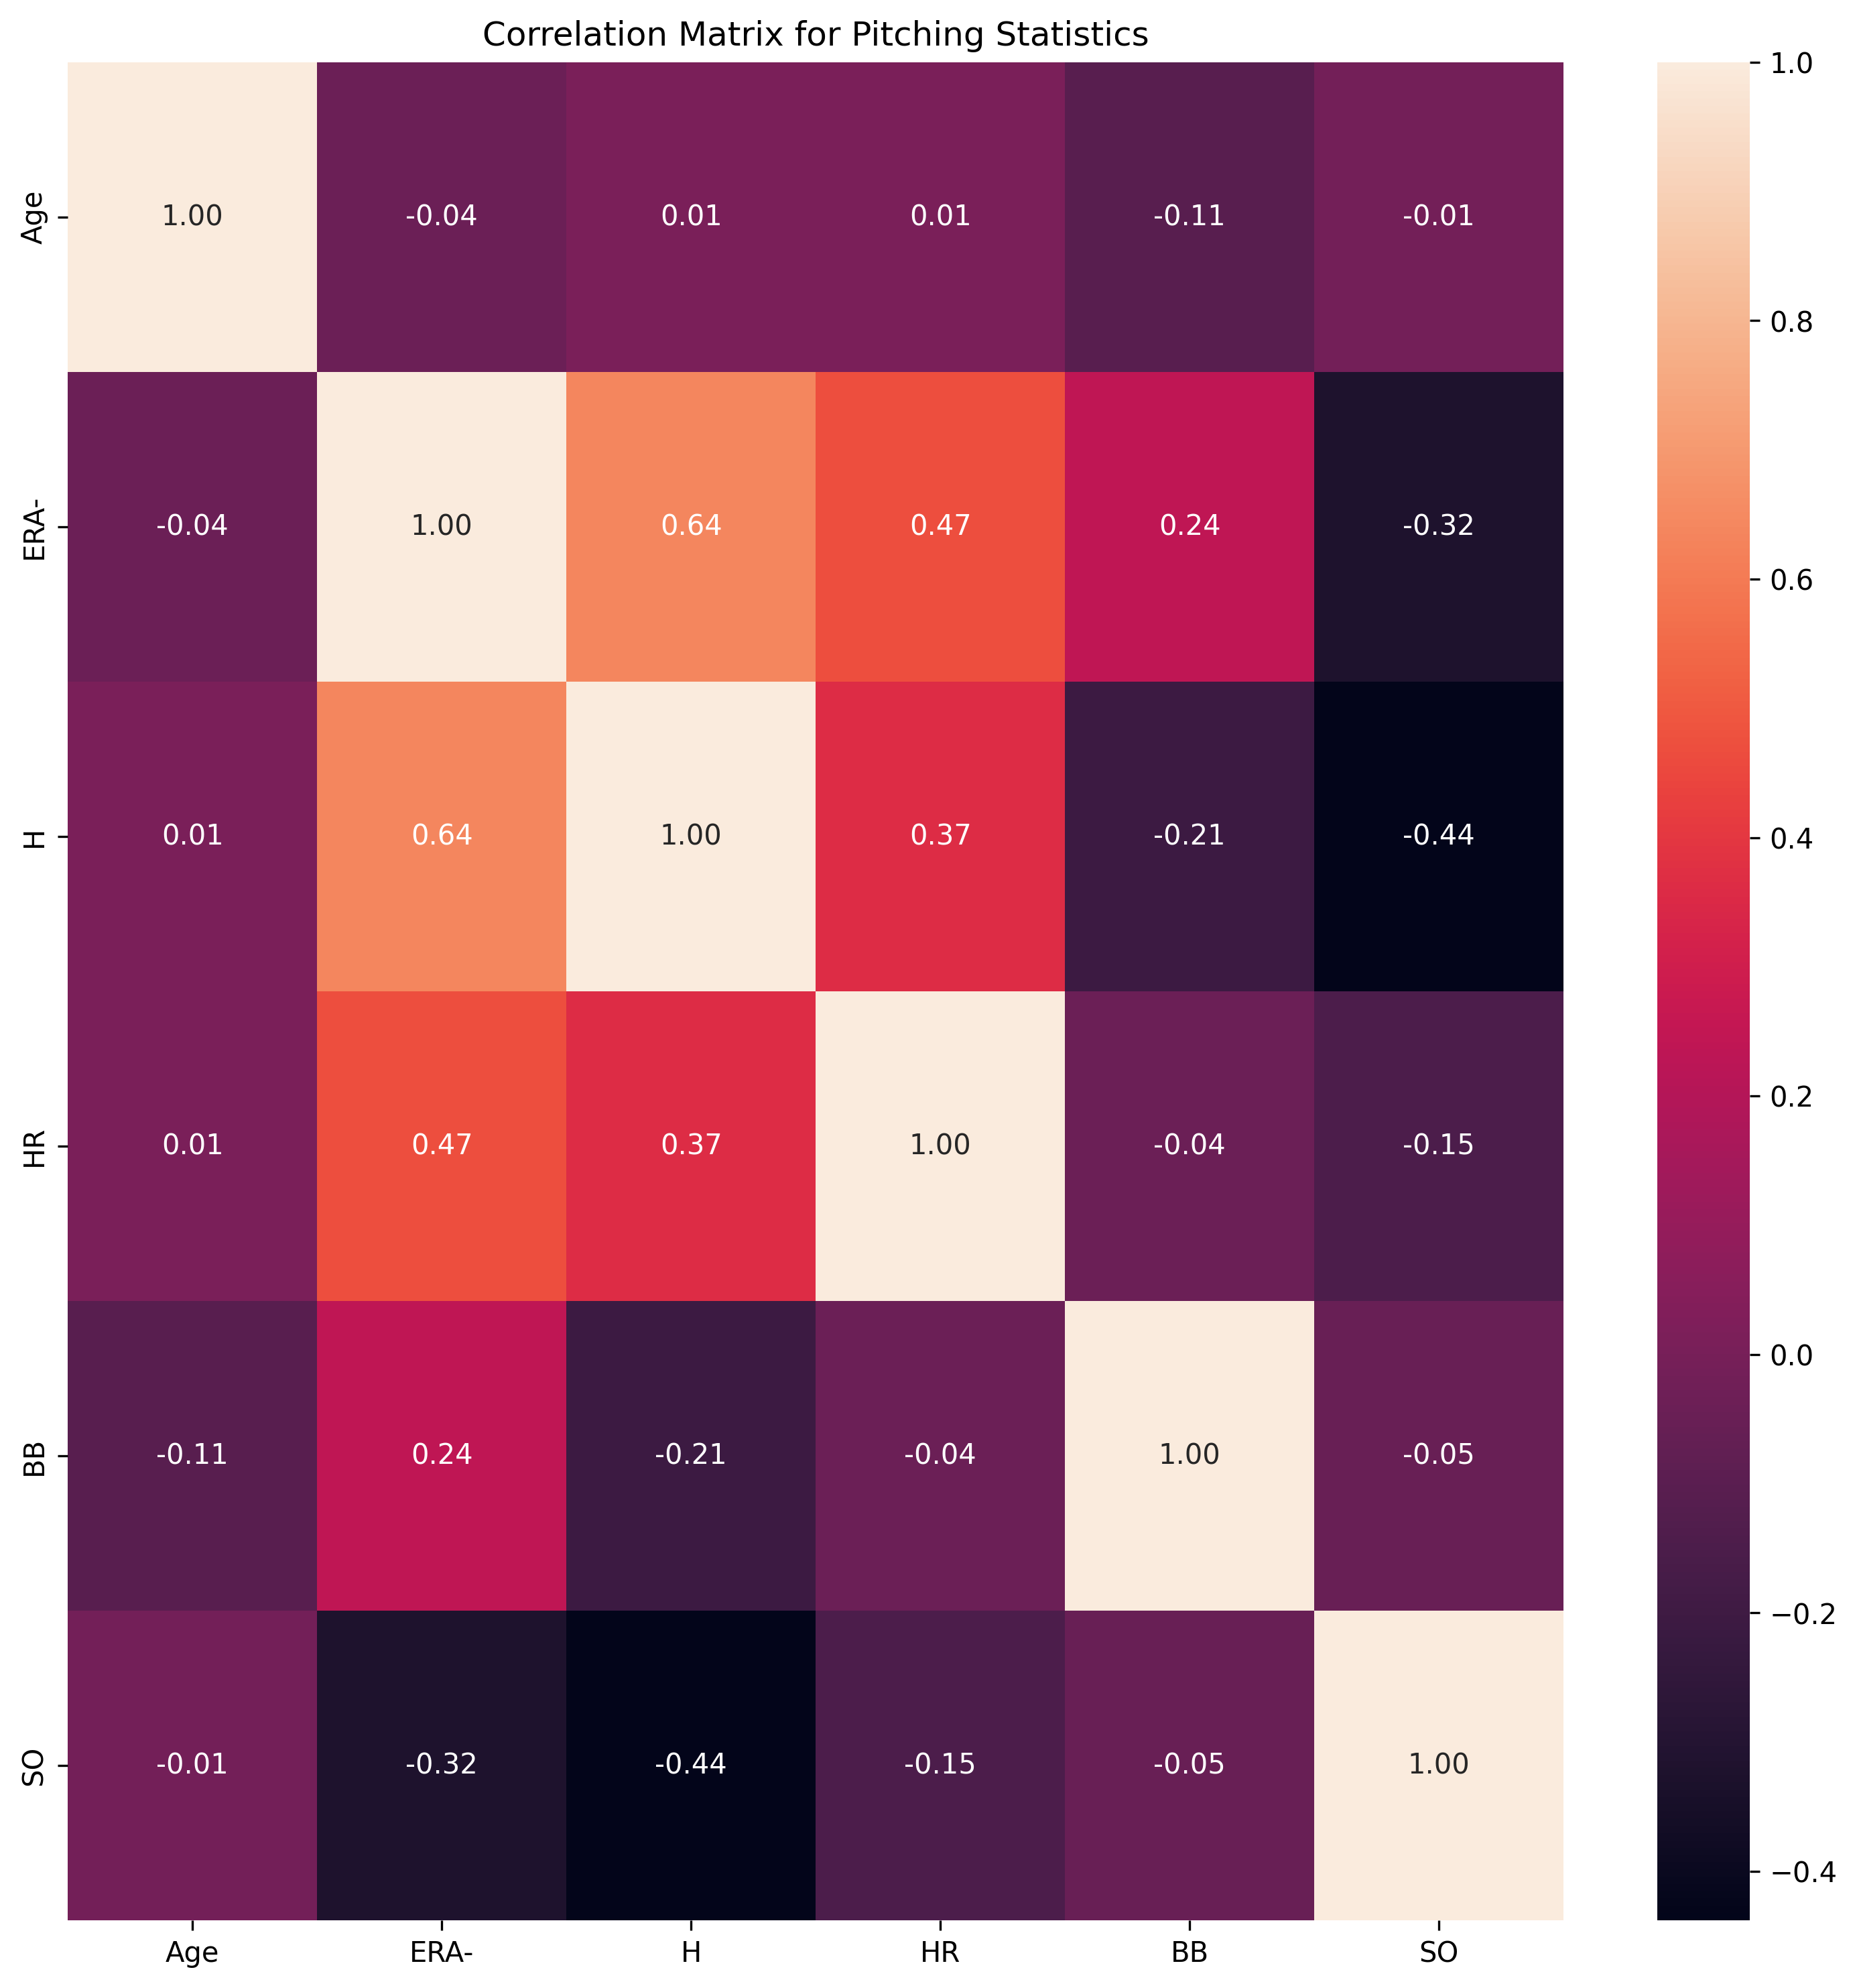

In [29]:
# Creating a correlation matrix for pitching statistics
plt.figure(figsize=(12, 12))
sns.heatmap(pitching_corr, annot=True, fmt=".2f")
plt.title("Correlation Matrix for Pitching Statistics")
plt.show()

# Model Selection + Training


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix

In [31]:
def best_accuracy(y_true, y_prob):
    best_acc = 0
    best_threshold = 0
    for threshold in np.linspace(0, 1, 100):
        y_pred = y_prob > threshold
        acc = accuracy_score(y_true, y_pred)
        if acc > best_acc:
            best_acc = acc
            best_threshold = threshold
    return best_acc, best_threshold

## Train/Test Split

In [32]:
seasons = final_data.Season.unique()
train_seasons, test_seasons = train_test_split(seasons, test_size=0.2, random_state=42)
train_mask = final_data.Season.isin(train_seasons)
X = final_data.drop(columns=["HomeTeam", "AwayTeam", "Win", "Date"]).copy()
y = final_data.Win

X_train = X[train_mask]
X_test = X[~train_mask]
y_train = y[train_mask]
y_test = y[~train_mask]

## Hyperparameter Optimized Logistic Regression

In [40]:
# Optuna LogisticRegression
def objective(trial):
    log_reg = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            random_state=0,
            penalty="elasticnet",
            max_iter=1000,
            solver="saga",
            C=trial.suggest_float("C", 1e-10, 1e5, log=True),
            l1_ratio=trial.suggest_float("l1_ratio", 0.0, 1.0),
        ),
    )
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    return accuracy_score(y_test, y_pred)


optuna.logging.set_verbosity(optuna.logging.WARNING)

log_reg_study = optuna.create_study(direction="maximize")
log_reg_study.optimize(objective, n_trials=1000)

In [41]:
trial = log_reg_study.best_trial

print("Accuracy: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
optuna.visualization.plot_slice(log_reg_study)

Accuracy: 0.5685862301974622
Best hyperparameters: {'C': 0.0031809804999613956, 'l1_ratio': 0.2325415220281672}


## Hyperparamter Optimized LGBM

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)


def objective(trial):
    lgb_model = lgb.train(
        {
            "objective": "binary",
            "metric": "binary_error",
            "verbose": -1,
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "max_depth": trial.suggest_int("max_depth", 1, 32),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-3, 1),
        },
        lgb_train,
        num_boost_round=1000,
        valid_sets=lgb_test,
        callbacks=[lgb.early_stopping(stopping_rounds=5)],
    )
    return lgb_model.best_score["valid_0"]["binary_error"]


optuna.logging.set_verbosity(optuna.logging.ERROR)

lgb_study = optuna.create_study(direction="minimize")
lgb_study.optimize(objective, n_trials=1000)

In [35]:
trial = lgb_study.best_trial

print("Best hyperparameters: {}".format(trial.params))
optuna.visualization.plot_slice(lgb_study)

Best hyperparameters: {'num_leaves': 79, 'max_depth': 16, 'learning_rate': 0.03786708236862938, 'feature_fraction': 0.4908471693279278, 'bagging_fraction': 0.8485129851690637, 'bagging_freq': 9, 'lambda_l1': 0.880260291304286}


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_error: 0.432915


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

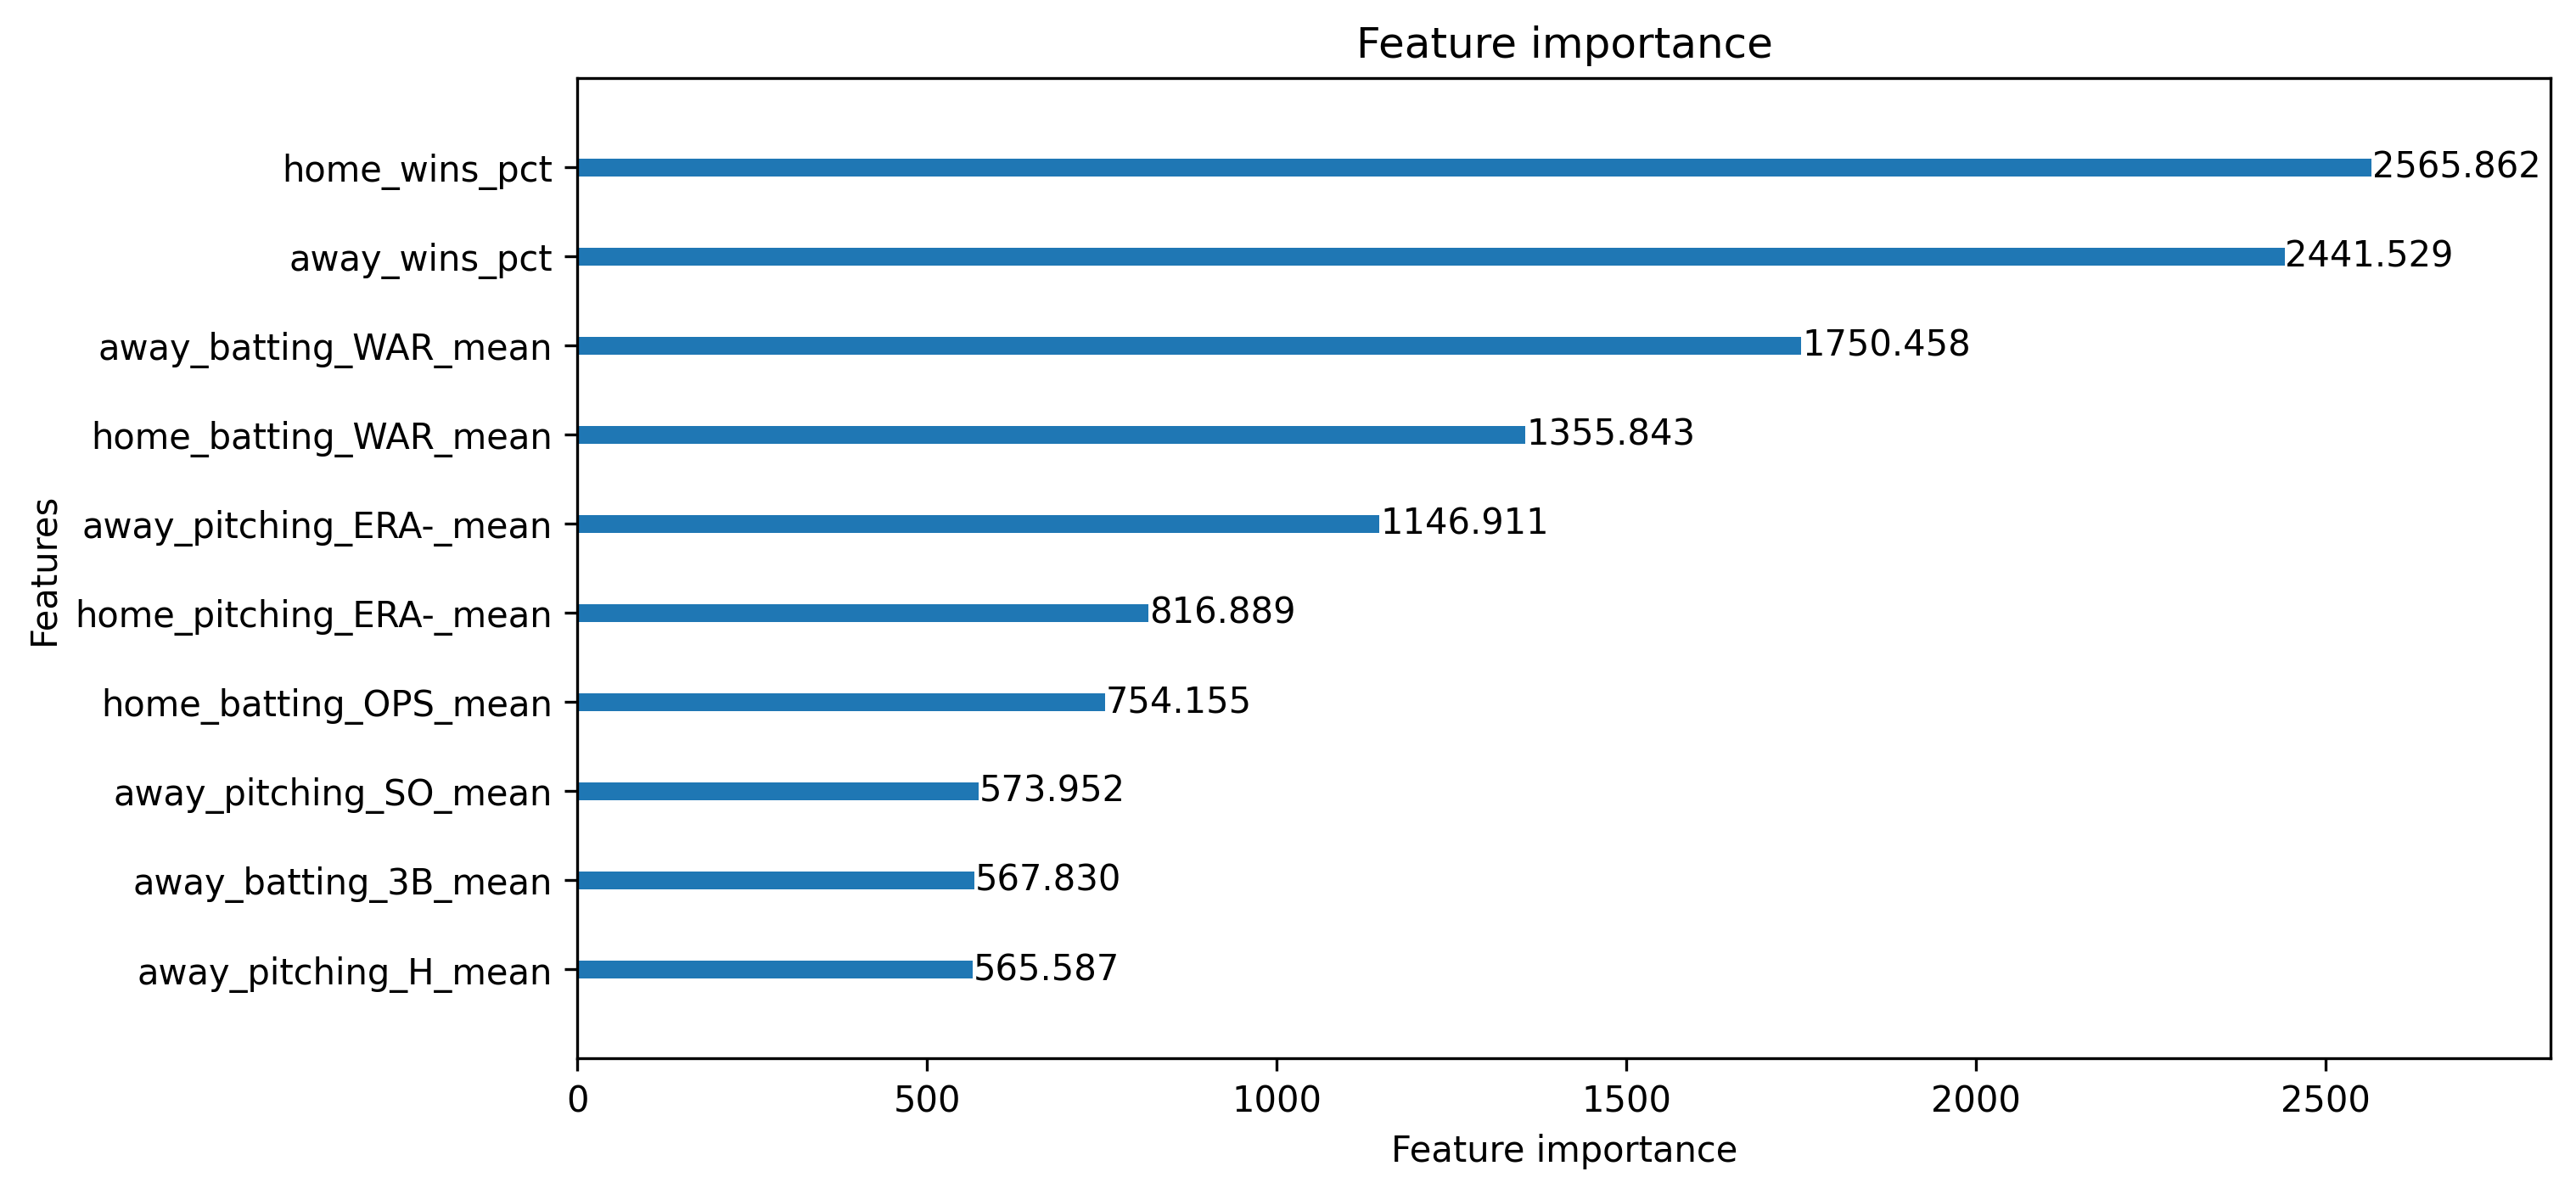

In [36]:
lgb_model = lgb.train(
    {
        "objective": "binary",
        "metric": "binary_error",
        "verbosity": -1,
        **trial.params,
    },
    lgb_train,
    num_boost_round=1000,
    valid_sets=lgb_test,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)
lgb.plot_importance(
    lgb_model, importance_type="gain", figsize=(10, 5), grid=False, max_num_features=10
)

In [38]:
# Acc
acc, thres = best_accuracy(y_test, lgb_model.predict(X_test))
print(f"LGBM Accuracy: {acc*100:.2f}%, with {thres:.2f} threshold")

LGBM Accuracy: 56.61%, with 0.49 threshold


## Feature Selection with RFECV

In [43]:
# RFECV with logistic regression
log_reg = make_pipeline(
    StandardScaler(),
    RFECV(
        LogisticRegression(
            random_state=0,
            penalty="elasticnet",
            max_iter=1000,
            solver="saga",
            **trial.params,
        ),
        cv=5,
    ),
)
log_reg.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rfecv',
                 RFECV(cv=5,
                       estimator=LogisticRegression(C=0.0031809804999613956,
                                                    l1_ratio=0.2325415220281672,
                                                    max_iter=1000,
                                                    penalty='elasticnet',
                                                    random_state=0,
                                                    solver='saga')))])

In [44]:
# What features?
selected_features = X_train.columns[log_reg.named_steps["rfecv"].support_]

In [45]:
selected_features

Index(['home_wins_pct', 'away_wins_pct', 'home_batting_R_mean',
       'home_batting_OPS_mean', 'home_batting_WAR_mean',
       'home_batting_rookies', 'home_pitching_H_mean', 'home_pitching_BB_mean',
       'home_pitching_SO_mean', 'home_pitching_rookies',
       'away_batting_OPS_mean', 'away_batting_WAR_mean',
       'away_batting_3B_mean', 'away_batting_rookies',
       'away_pitching_Age_mean', 'away_pitching_SO_mean',
       'away_pitching_rookies'],
      dtype='object')

In [46]:
len(selected_features)

17

In [47]:
len(X_train.columns)

96

## Feature Ablation

In [ ]:
def get_acc(feature_select):
    features = [f for f in X_train.columns if feature_select(f)]
    _X_train = X_train[features]
    _X_test = X_test[features]

    log_reg = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            penalty="l2",
            max_iter=1000,
            solver="saga",
        ),
    )
    log_reg.fit(_X_train, y_train)
    y_pred = log_reg.predict(_X_test)
    return accuracy_score(y_test, y_pred)

In [ ]:
# No Features
accuracy_score(y_test, np.ones_like(y_test))

0.5420076582326

In [ ]:
# All features
get_acc(lambda x: True)

0.5621292889856596

In [ ]:
# Just win percentage
get_acc(lambda x: x in ["home_wins_pct", "away_wins_pct"])

0.5539454914032585

In [ ]:
# Just win percentage and streak
get_acc(lambda x: x in ["home_wins_pct", "away_wins_pct", "home_streak", "away_streak"])

0.5524438771679555

In [ ]:
# No Variances
get_acc(lambda x: "_var" not in x)

0.5672347773856896

In [ ]:
# No Mean
get_acc(lambda x: "_mean" not in x)

0.558825737667993

In [ ]:
# Home-Only
get_acc(lambda x: "away_" not in x)

0.5543208949620843

In [ ]:
# Away-Only
get_acc(lambda x: "home_" not in x)

0.5519933928973647

In [ ]:
# RFE Features
get_acc(
    lambda x: x
    in [
        "home_wins_pct",
        "away_wins_pct",
        "mar",
        "home_batting_R_mean",
        "home_batting_OPS_mean",
        "home_batting_WAR_mean",
        "home_batting_rookies",
        "home_pitching_ERA-_mean",
        "home_pitching_BB_mean",
        "home_pitching_SO_mean",
        "home_pitching_rookies",
        "away_batting_WAR_mean",
        "away_batting_SO_var",
        "away_batting_rookies",
        "away_pitching_Age_mean",
        "away_pitching_Age_var",
        "away_pitching_ERA-_mean",
        "away_pitching_BB_mean",
        "away_pitching_SO_mean",
        "away_pitching_rookies",
    ]
)

0.5656580824386215

## Error Analysis

In [ ]:
# Confusion Matrix

log_reg = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        penalty="l2",
        max_iter=1000,
        solver="saga",
        **{"C": 0.006143534075514649, "l1_ratio": 0.8943970373411257},
    ),
)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 2349
False Positives: 3751
False Negatives: 2072
True Positives: 5147
